In [1]:
import torch
from IPython.display import Image, clear_output  # to display images
# from utils.google_utils import gdrive_download  # to download models/datasets

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.0.1+cu117 CPU


## Pretrained model test

In [11]:
!python detect.py --weights ./weights/yolov5x.pt --img 416 --conf 0.6 --source ./inference/images/

Traceback (most recent call last):
  File "/home/user/sharon/image/detect.py", line 3, in <module>
    from yolo.yolov5.utils.datasets import *
  File "/home/user/sharon/image/yolo/yolov5/utils/datasets.py", line 17, in <module>
    from yolo.yolov5.utils.utils import xyxy2xywh, xywh2xyxy
  File "/home/user/sharon/image/yolo/yolov5/utils/utils.py", line 12, in <module>
    import cv2
ModuleNotFoundError: No module named 'cv2'


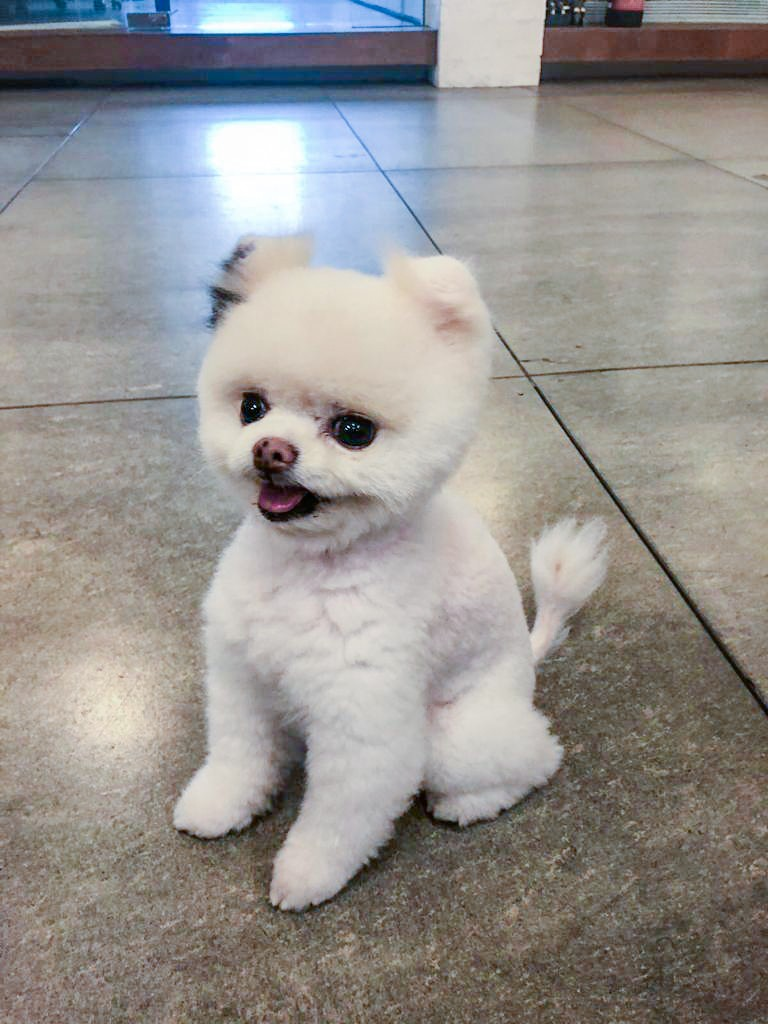

In [8]:
Image(filename='./inference/images/dog.jpg', width=200)

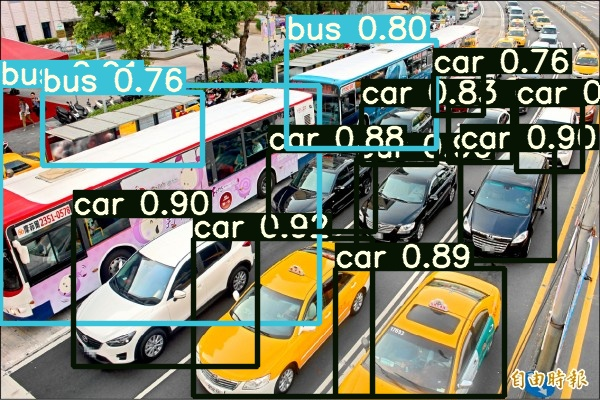

In [26]:
Image(filename='./inference/output/traffic.jpg', width=200)

## Training

In [ ]:
# Train YOLOv5x for 5 epochs
!python train.py --img 512 --batch 8 --epochs 120 --data ./data/thyroid.yaml --cfg ./models/thyroid.yaml --weights ./weights/yolov5x.pt

## Ploting result

In [2]:
import glob
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
def plot_results(save_path, start=0, stop=0, bucket='', id=(), labels=()):  # from utils.utils import *; plot_results()
    # Plot training 'results*.txt' as seen in https://github.com/ultralytics/yolov5#reproduce-our-training
    fig, ax = plt.subplots(2, 5, figsize=(12, 6))
    ax = ax.ravel()
    s = ['GIoU', 'Objectness', 'Classification', 'Precision', 'Recall',
         'val GIoU', 'val Objectness', 'val Classification', 'mAP@0.5', 'mAP@0.5:0.95']
    files = glob.glob(save_path)
    for fi, f in enumerate(files):
        results = np.loadtxt(f, usecols=[2, 3, 4, 8, 9, 12, 13, 14, 10, 11], ndmin=2).T
        n = results.shape[1]  # number of rows
        x = range(start, min(stop, n) if stop else n)
        for i in range(10):
            y = results[i, x]
            if i in [0, 1, 2, 5, 6, 7]:
                y[y == 0] = np.nan  # dont show zero loss values
                # y /= y[0]  # normalize
            label = labels[fi] if len(labels) else Path(f).stem
            ax[i].plot(x, y, marker='.', label=label, linewidth=2, markersize=8)
            ax[i].set_title(s[i])
            # if i in [5, 6, 7]:  # share train and val loss y axes
            #     ax[i].get_shared_y_axes().join(ax[i], ax[i - 5])

    fig.tight_layout()
    ax[1].legend()
#     fig.savefig(save_path + 'results.png', dpi=200)

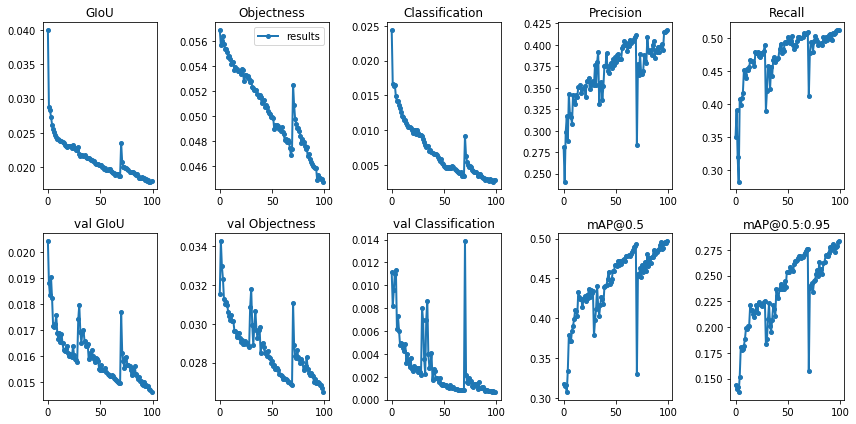

In [38]:
save_path = 'D:/108/yolo/yolov5/save_folder/20200620_72/results.txt'
plot_results(save_path)

## Predict test image

要存出txt檔，直接修改code裡面save_txt改成True<br>
不要存圖就把save_img那邊全註解掉

In [ ]:
!python detect.py --img-size 512 --source D:/108/yolo/data/torch_train/images/val/ --weights ./save_folder/20200620_100/weights/best.pt --conf 0.1

In [ ]:
!python test.py --img-size 512 --data ./data/thyroid.yaml --weights ./save_folder/20200620_100/weights/best.pt --verbose

## Test.py

In [2]:
import pandas as pd
import argparse
import json
from torch.utils.data import DataLoader
from utils.datasets import *
from utils.utils import *

In [3]:
data = './data/thyroid.yaml'
weights = './save_folder/20210208/weights/best.pt' #改日期
batch_size=16
imgsz=512
conf_thres=0.001
iou_thres=0.6  # for NMS
save_json=False
single_cls=False
augment=False
verbose=True
model=None
dataloader=None
fast=False

In [4]:
# Initialize/load model and set device
if model is None:
    training = False
    device = torch_utils.select_device('gpu', batch_size=batch_size)
    half = device.type != 'cpu'  # half precision only supported on CUDA

    # Remove previous
    for f in glob.glob('test_batch*.jpg'):
        os.remove(f)

    # Load model
    google_utils.attempt_download(weights)
    model = torch.load(weights, map_location=device)['model'].float()  # load to FP32
    torch_utils.model_info(model)
    model.fuse()
    model.to(device)
    if half:
        model.half()  # to FP16

    # Multi-GPU disabled, incompatible with .half()
    # if device.type != 'cpu' and torch.cuda.device_count() > 1:
    #     model = nn.DataParallel(model)

else:  # called by train.py
    training = True
    device = next(model.parameters()).device  # get model device
    # half disabled https://github.com/ultralytics/yolov5/issues/99
    half = False  # device.type != 'cpu' and torch.cuda.device_count() == 1
    if half:
        model.half()  # to FP16

Using CUDA device0 _CudaDeviceProperties(name='GeForce RTX 2080 Ti', total_memory=11264MB)

Model Summary: 381 layers, 9.54172e+07 parameters, 0 gradients
Fusing layers...
Model Summary: 264 layers, 9.53734e+07 parameters, 9.20716e+07 gradients


In [5]:
# Configure
model.eval()
with open(data) as f:
    data = yaml.load(f, Loader=yaml.FullLoader)  # model dict
nc = 1 if single_cls else int(data['nc'])  # number of classes
iouv = torch.linspace(0.5, 0.95, 10).to(device)  # iou vector for mAP@0.5:0.95
# iouv = torch.linspace(0, 0.95, 10).to(device)
# iouv = iouv[0].view(1)  # comment for mAP@0.5:0.95
niou = iouv.numel()

# add save_path
save_path = data['save_folder']

# Dataloader
if dataloader is None:  # not training
    img = torch.zeros((1, 3, imgsz, imgsz), device=device)  # init img
    _ = model(img.half() if half else img) if device.type != 'cpu' else None  # run once

    fast |= conf_thres > 0.001  # enable fast mode
    path = data['val']  # path to val/test images
    dataset = LoadImagesAndLabels(path,
                                  imgsz,
                                  batch_size,
                                  rect=True,  # rectangular inference
#                                   single_cls=opt.single_cls,  # single class mode
                                  pad=0.5)  # padding
    batch_size = min(batch_size, len(dataset))
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            num_workers=nw,
                            pin_memory=True,
                            collate_fn=dataset.collate_fn)

Caching labels D:\108\yolo\data\torch_train\labels20210128\val.npy (9850 found, 0 missing, 0 empty, 19 duplicate, for 9


In [11]:
model.names

['PTC', 'FCs', 'Histiocytes', 'PMNs', 'indeterminate']

In [6]:
seen = 0
names = model.names if hasattr(model, 'names') else model.module.names
coco91class = coco80_to_coco91_class()
s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Targets', 'P', 'R', 'mAP@.5', 'mAP@.5:.95')
p, r, f1, mp, mr, map50, map90, t0, t1 = 0., 0., 0., 0., 0., 0., 0., 0., 0.
loss = torch.zeros(3, device=device)

In [7]:
iou_list = []
jdict, stats, ap, ap_class = [], [], [], []
for batch_i, (img, targets, paths, shapes) in enumerate(tqdm(dataloader, desc=s)):
    img = img.to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    targets = targets.to(device)
    nb, _, height, width = img.shape  # batch size, channels, height, width
    whwh = torch.Tensor([width, height, width, height]).to(device)

    # Disable gradients
    with torch.no_grad():
        # Run model
        t = torch_utils.time_synchronized()
        inf_out, train_out = model(img, augment=augment)  # inference and training outputs
        t0 += torch_utils.time_synchronized() - t

        # Compute loss
        if training:  # if model has loss hyperparameters
            loss += compute_loss([x.float() for x in train_out], targets, model)[1][:3]  # GIoU, obj, cls

        # Run NMS
        t = torch_utils.time_synchronized()
        output = non_max_suppression(inf_out, conf_thres=conf_thres, iou_thres=iou_thres, fast=fast)
        t1 += torch_utils.time_synchronized() - t

    # Statistics per image
    for si, pred in enumerate(output):
        labels = targets[targets[:, 0] == si, 1:]
        nl = len(labels)
        tcls = labels[:, 0].tolist() if nl else []  # target class
        seen += 1

        if pred is None:
            if nl:
                stats.append((torch.zeros(0, niou, dtype=torch.bool), torch.Tensor(), torch.Tensor(), tcls))
            continue

        # Append to text file
        # with open('test.txt', 'a') as file:
        #    [file.write('%11.5g' * 7 % tuple(x) + '\n') for x in pred]

        # Clip boxes to image bounds
        clip_coords(pred, (height, width))

        # Append to pycocotools JSON dictionary
        if save_json:
            # [{"image_id": 42, "category_id": 18, "bbox": [258.15, 41.29, 348.26, 243.78], "score": 0.236}, ...
            image_id = int(Path(paths[si]).stem.split('_')[-1])
            box = pred[:, :4].clone()  # xyxy
            scale_coords(img[si].shape[1:], box, shapes[si][0], shapes[si][1])  # to original shape
            box = xyxy2xywh(box)  # xywh
            box[:, :2] -= box[:, 2:] / 2  # xy center to top-left corner
            for p, b in zip(pred.tolist(), box.tolist()):
                jdict.append({'image_id': image_id,
                              'category_id': coco91class[int(p[5])],
                              'bbox': [round(x, 3) for x in b],
                              'score': round(p[4], 5)})

        # Assign all predictions as incorrect
        correct = torch.zeros(pred.shape[0], niou, dtype=torch.bool, device=device)
        if nl:
            detected = []  # target indices
            tcls_tensor = labels[:, 0]

            # target boxes
            tbox = xywh2xyxy(labels[:, 1:5]) * whwh

            # Per target class
            for cls in torch.unique(tcls_tensor):
                ti = (cls == tcls_tensor).nonzero().view(-1)  # prediction indices
                pi = (cls == pred[:, 5]).nonzero().view(-1)  # target indices

                # Search for detections
                if pi.shape[0]:
                    # Prediction to target ious
                    ious, i = box_iou(pred[pi, :4], tbox[ti]).max(1)  # best ious, indices

                    # Append detections
                    for j in (ious > iouv[0]).nonzero():
                        d = ti[i[j]]  # detected target
                        if d not in detected:
                            detected.append(d)
                            correct[pi[j]] = ious[j] > iouv  # iou_thres is 1xn
                            iou_list.append([d.item(), ious[j].item()]) # add label & mAP
                            if len(detected) == nl:  # all targets already located in image
                                break

        # Append statistics (correct, conf, pcls, tcls)
        stats.append((correct.cpu(), pred[:, 4].cpu(), pred[:, 5].cpu(), tcls))

               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100%|█| 616/616 [04:16<00


In [9]:
iouv

tensor([0.50000, 0.55000, 0.60000, 0.65000, 0.70000, 0.75000, 0.80000, 0.85000, 0.90000, 0.95000], device='cuda:0')

In [146]:
ap

array([[    0.86924,     0.81151,     0.76226,     0.70828,     0.63143,      0.5452,      0.4284,     0.27137,    0.087388,   0.0094145],
       [    0.90823,     0.87407,     0.83914,     0.77999,     0.71343,     0.57898,     0.43033,     0.21023,     0.05478,   0.0015363],
       [    0.78822,     0.72809,      0.7031,      0.6503,     0.55923,     0.46083,     0.32569,     0.17911,    0.049472,   0.0031325],
       [          0,           0,           0,           0,           0,           0,           0,           0,           0,           0],
       [          0,           0,           0,           0,           0,           0,           0,           0,           0,           0]])

In [8]:
# Compute statistics
stats2 = [np.concatenate(x, 0) for x in zip(*stats)]  # to numpy
if len(stats2):
    p, r, ap, f1, ap_class = ap_per_class(*stats2)
#     p, r, ap50, ap = p[:, 0], r[:, 0], ap[:, 0], ap.mean(1)  # [P, R, AP@0.5, AP@0.5:0.95]
#     mp, mr, map50, map90 = p.mean(), r.mean(), ap50.mean(), ap.mean()
    p, r, ap50, ap60, ap70, ap80, ap90 = p[:, 0], r[:, 0], ap[:, 0], ap[:, 2], ap[:, 4], ap[:, 6], ap[:, 8]
    mp, mr, map50, map60, map70, map80, map90 = p.mean(), r.mean(), ap50.mean(), ap60.mean(), ap70.mean(), ap80.mean(), ap90.mean()
    nt = np.bincount(stats2[3].astype(np.int64), minlength=nc)  # number of targets per class
else:
    nt = torch.zeros(1)

### Each class statistics

In [13]:
# Print results
pf = '%15s' + '%12.3g' * 9  # print format
print(pf % ('all', seen, nt.sum(), mp, mr, map50, map60, map70, map80, map90))

# Print results per class
if verbose and nc > 1 and len(stats):
    for i, c in enumerate(ap_class):
        print(pf % (names[c], seen, nt[c], p[i], r[i], ap50[i], ap60[i], ap70[i], ap80[i], ap90[i]))

            all    2.47e+03    2.52e+03       0.413       0.497       0.478       0.433       0.346       0.176      0.0205
            PTC    2.47e+03    1.66e+03       0.732       0.836       0.839       0.742       0.574       0.336      0.0581
            FCs    2.47e+03         726       0.775       0.876       0.872       0.803       0.624       0.306      0.0414
    Histiocytes    2.47e+03         133        0.56       0.776        0.68       0.619       0.531       0.237     0.00279
           PMNs    2.47e+03           1           0           0           0           0           0           0           0
  indeterminate    2.47e+03           1           0           0           0           0           0           0           0


In [117]:
# Print results
pf = '%15s' + '%12.3g' * 9  # print format
print(pf % ('all', seen, nt.sum(), mp, mr, map50, map60, map70, map80, map90))

# Print results per class
if verbose and nc > 1 and len(stats):
    for i, c in enumerate(ap_class):
        print(pf % (names[c], seen, nt[c], p[i], r[i], ap50[i], ap60[i], ap70[i], ap80[i], ap90[i]))

            all    2.47e+03    2.52e+03       0.443       0.526       0.513       0.461       0.381       0.237      0.0383
            PTC    2.47e+03    1.66e+03       0.761        0.86       0.869       0.762       0.631       0.428      0.0874
            FCs    2.47e+03         726       0.819        0.89       0.908       0.839       0.713        0.43      0.0548
    Histiocytes    2.47e+03         133       0.634        0.88       0.788       0.703       0.559       0.326      0.0495
           PMNs    2.47e+03           1           0           0           0           0           0           0           0
  indeterminate    2.47e+03           1           0           0           0           0           0           0           0


In [118]:
a = []
a.append(('all', seen, nt.sum(), '{:.3f}'.format(mp), '{:.3f}'.format(mr), '{:.3f}'.format(map50), '{:.3f}'.format(map60), '{:.3f}'.format(map70), '{:.3f}'.format(map80), '{:.3f}'.format(map90)))
if verbose and nc > 1 and len(stats):
    for i, c in enumerate(ap_class):
        a.append((names[c], seen, nt[c], '{:.3f}'.format(p[i]), '{:.3f}'.format(r[i]), '{:.3f}'.format(ap50[i]), '{:.3f}'.format(ap60[i]), '{:.3f}'.format(ap70[i]), '{:.3f}'.format(ap80[i]), '{:.3f}'.format(ap90[i])))

In [119]:
pd.DataFrame(a, columns=['Class', 'Images', 'Targets', 'Precision', 'Recall', 'mAP@50', 'mAP@60', 'mAP@70', 'mAP@80', 'mAP@90'])

,Class,Images,Targets,Precision,Recall,mAP@50,mAP@60,mAP@70,mAP@80,mAP@90
0,all,2466,2524,0.443,0.526,0.513,0.461,0.381,0.237,0.038
1,PTC,2466,1663,0.761,0.860,0.869,0.762,0.631,0.428,0.087
2,FCs,2466,726,0.819,0.890,0.908,0.839,0.713,0.430,0.055
3,Histiocytes,2466,133,0.634,0.880,0.788,0.703,0.559,0.326,0.049
4,PMNs,2466,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,indeterminate,2466,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [120]:
2466-726

1740

In [15]:
min(iou_list)

0.5000081658363342

In [122]:
df_val = pd.DataFrame(os.listdir('D:/108/yolo/data/torch_train/images/val/'))

In [133]:
val_label = []
for i in os.listdir('D:/108/yolo/data/torch_train/labels/val/'):
    val_label.append(open('D:/108/yolo/data/torch_train/labels/val/' + i).read().split(' ')[0])

In [136]:
pd.DataFrame(val_label)[0].value_counts()

0    1620
1     716
2     128
4       1
3       1
Name: 0, dtype: int64

In [137]:
716*0.89

637.24

In [138]:
638/716

0.8910614525139665

In [139]:
716-638

78

In [140]:
1740-78

1662

In [141]:
1662/1750

0.9497142857142857

In [142]:
1620*0.86

1393.2

In [143]:
1620-1393

227

In [144]:
803-227

576

In [145]:
576/846

0.6808510638297872

## predict txt

將單一張預測的細胞團塊對應回該張slide上

In [23]:
import os
import pandas as pd
from tqdm import tqdm_notebook
pd.set_option('display.max_rows', None)

In [17]:
data = open('D:/108/yolo/yolov5/save_folder/20200620_100/predict_txt/BFC_12_015_S10336.txt')
content = data.read()
data.close()

In [42]:
name, detect = [], []
for i in tqdm_notebook(os.listdir('D:/108/yolo/yolov5/save_folder/20200620_100/predict_txt/')):
    data = open('D:/108/yolo/yolov5/save_folder/20200620_100/predict_txt/'+i)
    content = data.read()
    # 可能辨識出兩個以上的團塊
    for k in content.split('\n'):
        if len(k.split(' ')[0]) != 0:
            if 'I' in i:
                name.append(i.split('_')[0])
            else:
                name.append(i.split('_')[0] +'_'+ i.split('_')[1] +'_'+ i.split('_')[2])
            if k.split(' ')[0] == '0':
                detect.append('PTC')
            elif k.split(' ')[0] == '1':
                detect.append('FCs')
            elif k.split(' ')[0] == '2':
                detect.append('Histiocytes')

C:\Users\dede\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [44]:
df = pd.DataFrame(list(zip(name, detect)), columns=['slide_name', 'detect'])

In [47]:
pd.DataFrame(df.groupby(['slide_name','detect'])['detect'].count())

detect
slide_name      detect             
BFC_12_015      FCs              66
BFC_19_001-HT   FCs              68
                PTC               1
BFC_19_002      FCs              41
                Histiocytes      59
                PTC               2
BFC_19_003      FCs              66
BFC_19_005      FCs              84
BFC_19_007      FCs              58
                PTC               1
BFC_19_008-HT   FCs              45
BFC_19_009-CYST FCs              47
                Histiocytes      58
BFC_19_010-CYST FCs               3
                Histiocytes      79
BFC_19_011-HT   FCs              58
BFC_19_012-HT   FCs              27
BFC_19_013      FCs              28
                PTC               1
BFC_19_014-HT   FCs              20
BFC_19_016-HT   FCs              27
BFC_19_017-HT   FCs              33
BFC_19_018      FCs              65
                PTC               2
BFC_19_019-HT   FCs              66
                PTC               2
I1910917        PTC              52
I1911116        PTC              43
I1911334        PTC              50
I1911468        PTC              70
I1911469        Histiocytes       1
                PTC              55
I1912042        PTC              63
PTC_18_014-C    PTC              28
PTC_18_019-C    PTC               8
PTC_18_022-C    PTC              53
PTC_18_023-C    PTC              72
PTC_18_036      PTC              20
PTC_18_039      PTC              16
PTC_18_061      PTC              33
PTC_18_085      FCs               1
                PTC              49
PTC_18_096      PTC              76
PTC_18_121      PTC              33
PTC_19_002      PTC              69
PTC_19_009      PTC              27
PTC_19_010      FCs               1
                PTC              64
PTC_19_011      PTC               5
PTC_19_012      PTC              73
PTC_19_013      PTC              69
PTC_19_014      PTC              52
PTC_19_015      PTC              24
PTC_19_016      PTC              79
PTC_19_018      PTC              80
PTC_19_019      PTC              57
PTC_19_020      PTC              68
PTC_19_022      PTC               7
PTC_19_023      PTC              53
PTC_19_024      PTC              61
PTC_19_026      FCs               2
                PTC              54
PTC_19_027      PTC              63
PTC_19_029      PTC              19
PTC_19_030      PTC              15
PTC_19_033      PTC              76
PTC_19_120-C    FCs               1
                PTC              83

## 20210208 result

In [9]:
a = []
a.append(('all', seen, nt.sum(), '{:.3f}'.format(mp), '{:.3f}'.format(mr), '{:.3f}'.format(map50), '{:.3f}'.format(map60), '{:.3f}'.format(map70), '{:.3f}'.format(map80), '{:.3f}'.format(map90)))
if verbose and nc > 1 and len(stats):
    for i, c in enumerate(ap_class):
        a.append((names[c], seen, nt[c], '{:.3f}'.format(p[i]), '{:.3f}'.format(r[i]), '{:.3f}'.format(ap50[i]), '{:.3f}'.format(ap60[i]), '{:.3f}'.format(ap70[i]), '{:.3f}'.format(ap80[i]), '{:.3f}'.format(ap90[i])))

In [13]:
ap_class

array([0, 1, 2, 4])

In [10]:
pd.DataFrame(a, columns=['Class', 'Images', 'Targets', 'Precision', 'Recall', 'mAP@50', 'mAP@60', 'mAP@70', 'mAP@80', 'mAP@90'])

,Class,Images,Targets,Precision,Recall,mAP@50,mAP@60,mAP@70,mAP@80,mAP@90
0,all,9850,9982,0.789,0.925,0.923,0.878,0.820,0.586,0.396
1,PTC,9850,5731,0.814,0.909,0.918,0.854,0.771,0.642,0.416
2,FCs,9850,4029,0.874,0.943,0.954,0.904,0.834,0.711,0.467
3,Histiocytes,9850,213,0.732,0.850,0.857,0.793,0.713,0.610,0.380
4,indeterminate,9850,9,0.735,1.000,0.963,0.963,0.963,0.380,0.320
